In [1]:
from pettingzoo.utils.env import ParallelEnv
import networkx as nx
import functools
import gymnasium
import numpy as np
from gymnasium.spaces import Discrete
from pettingzoo import AECEnv
from pettingzoo.utils import agent_selector, wrappers
import matplotlib.pyplot as plt
from pettingzoo.test import parallel_api_test   

In [2]:
class CustomEnvironment(ParallelEnv):
    
    metadata = {
        "name": "custom_graph_environment_2_Agent",
    }
    def __init__(self):
        # this is the graph
        self.g_env = nx.read_graphml('g1.gml')
        self.g_no_node = len(self.g_env.nodes())
        self.node_list = list(self.g_env.nodes())
        
        # A dictionary that relates each discrete value in the observation
        # space to a node obtained from the graph
        
            # 1. Create empty dictionary
        self.node_dict = {}
        self.node_inv_dict = {}
        
            # 2. relating the key to the value of the node
        for key,value in enumerate(self.node_list):
            self.node_dict[key] = value 
            
            # 3. relating the value to the key ( used later on )
        self.node_inv_dict = {value: key for key, value in self.node_dict.items()}
        
        # sets the maximum steps after which the program will terminate 
        self.max_steps = 100
        self.step_now = 0
        
        self.no_of_thieves = 1
        self.no_of_police = 1
        self.possible_thieves = ['thief_'+str(r) for r in range (self.no_of_thieves)]
        self.possible_police = ['police_'+str(r) for r in range (self.no_of_police)]
        self.possible_agents = self.possible_thieves.copy() + self.possible_police.copy()
        self.agent_name_mapping = dict(
            zip(self.possible_agents, list(range(len(self.possible_agents))))
        )
        self._action_spaces = {agent: Discrete(4) for agent in self.possible_agents}
        self._observation_spaces = {
            agent: Discrete(self.g_no_node**len(self.possible_agents)) for agent in self.possible_agents
        }
        
        self.agents = [i for i in self.possible_agents]
        self.infos = {agent: {} for agent in self.possible_agents}
        self.state = {agent: None for agent in self.possible_agents}
        
        # not utilized
        self._cumulative_rewards = {agent: 0 for agent in self.possible_agents}
        
                
        # this is extra things for visualization you do not need to know
        graph = self.g_env
        position = list(graph.nodes())
        position = [self.str_to_tuple(name) for name in position]
        pos = dict(zip(graph.nodes(), position))
        self.node_positions = pos
        
        # sets the current state of agents
        self.terminations = {agent:False for agent in self.possible_agents}

        for thief in self.possible_thieves:
            self.state[thief]= self.node_dict[2]
            
        for police in self.possible_police:
            self.state[police]= self.node_dict[12]
            
        #forced by testing api
        self.action_spaces = self._action_spaces
        self.observation_spaces = self._observation_spaces
        
        
        
    def reset(self, seed=None, options=None):
        self.agents = [i for i in self.possible_agents]
        self.timestep = None
        self.state = {agent: None for agent in self.possible_agents}
        self._cumulative_rewards = {agent: 0 for agent in self.agents}
        self.step_now = 0
        self.terminations = {agent:False for agent in self.possible_agents}

#         ran = np.random.randint(0,self.g_no_node)     # later on if you have to start at random places
        for thief in self.possible_thieves:
            self.state[thief]= self.node_dict[5]
            
        for police in self.possible_police:
            self.state[police]= self.node_dict[12]
        return self.state

    def step(self, actions):
        
        # observation returns the next state of the agents
        # for each action selected for the agent the observations sould be sent back
        # the impletentation is bad change if possible
        terminations = self.terminations 
        rewards = {}
#         for agent in self.possible_agents:
#             rewards[agent] = None  
        agents = self.agents.copy()
        state = self.state
        # movement of the thief and the police according to the action and their rewards       
        for agent in self.agents:
            temp_neighbours = []
            for neighbour in self.g_env.neighbors(state[agent]):
                temp_neighbours.append(neighbour)
    
            if actions[agent] < len([i for i in self.g_env.neighbors(state[agent])]):
                rewards[agent] = -6;
                self.state[agent] = temp_neighbours[actions[agent]]
                
            elif actions[agent] == len([i for i in self.g_env.neighbors(state[agent])]):
                rewards[agent] = -2;
                
            else:
                rewards[agent] = -10;
                
#         extra reward for thief for running away
#         if (self.step_now>7):
#             for thief in self.possible_thieves:
#                 rewards[thief] += 20
#             for police in self.possible_police:
#                 rewards[police] -= 20

        self.step_now += 1
        self.terminations  = terminations
        
        
        
        # Get dummy infos (not used in this example)
        infos = {a: {} for a in self.agents}
        observations = {a: self.state[a] for a in self.agents}
        truncations = {a: None for a in self.agents}
        terminations = {a: False for a in self.agents}
        self.agents = agents
        
        
        # termination if on the same place
        for thief in self.possible_thieves:
            if thief in self.agents:
                for police in self.possible_police:
                    if self.state[police] == self.state[thief]:
                        terminations[thief] = True
                        rewards[police] = 10 
        
        # agents exist if alive/not terminated
        for i in self.agents:
            if terminations[i] == True:
                agents.remove(i)
        self.agents = agents
            
        return observations, rewards, terminations, truncations, infos
    
    def render(self):
        pass
    

    def temp_render(self,episode):
        
        nx.draw(self.g_env, self.node_positions,node_size=300)

        nx.draw_networkx_labels(self.g_env, self.node_positions,labels = self.node_inv_dict,font_color='black' )
        
        # drawing the agents
        for agent in self.agents:
            x,y = self.node_positions[str(self.state[agent])]
            if agent in self.possible_police:
                plt.scatter(x, y, s=550, c='yellow')
            elif agent in self.possible_thieves:
                plt.scatter(x, y, s=450, c='red')
        
        filename = f"images/Multi_2_Agent{episode}_{self.step_now}.png"

        plt.savefig(filename)
        plt.show()

    def observation_space(self, agent):
        return self.observation_spaces[agent]

    def action_space(self, agent):
        return self.action_spaces[agent]
    
    def str_to_tuple(self,string):
        return tuple(float(x) for x in string.strip('()').split(','))
    
    def possible_move_range(self,player):
        return len(list(self.g_env.neighbors(self.state[player])))

In [10]:
env= CustomEnvironment()

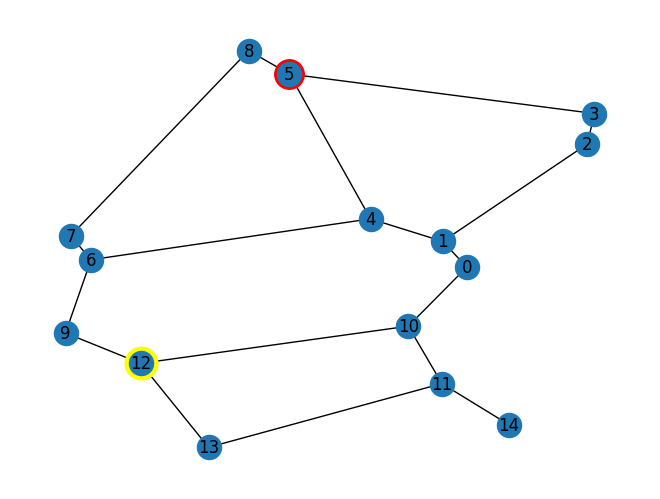

In [11]:
env.reset()
env.temp_render(1)

In [12]:
state = env.state.copy()
state

{'thief_0': '(0.44811437238452245, 0.9045289990489157)',
 'police_0': '(0.2831911754505866, 0.2787555382740357)'}

{'thief_0': 2, 'police_0': 2}
{'thief_0': '(0.44811437238452245, 0.9045289990489157)', 'police_0': '(0.2831911754505866, 0.2787555382740357)'}
{'thief_0': '(0.4028840030738831, 0.9550652406422548)', 'police_0': '(0.3584447216903549, 0.09709933172300317)'}
{'thief_0': -6, 'police_0': -6}


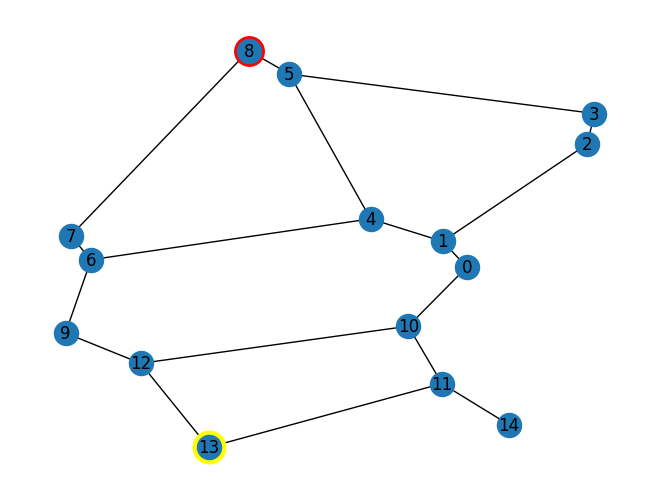

In [13]:
action = {agent:2 for agent in env.possible_agents}
print(action)
print(env.state)
observations, rewards, terminations, truncations, infos = env.step(action)
print(env.state)
print(rewards)
env.temp_render(1)

In [14]:
state = env.state
print(env.state)
print(env.node_inv_dict[state['police_0']])
print(env.node_inv_dict[state['thief_0']])
print([i for i in env.g_env.neighbors(state['police_0'])])
print([i for i in env.g_env.neighbors(state['thief_0'])])

{'thief_0': '(0.4028840030738831, 0.9550652406422548)', 'police_0': '(0.3584447216903549, 0.09709933172300317)'}
13
8
['(0.6171489120032924, 0.23498045883754137)', '(0.2831911754505866, 0.2787555382740357)']
['(0.44811437238452245, 0.9045289990489157)', '(0.20552139150292098, 0.554666334735012)']
